In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, random
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input, merge
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten, MaxoutDense
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconv2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import cPickle, random, sys, keras
from IPython import display
from keras.models import Model
sys.path.append("../common")
from keras.utils import np_utils
from tqdm import tqdm

K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [2]:
img_rows, img_cols = 28, 28
#The data shuffled and split between train and test sets

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train/ 255.
X_test = X_test / 255.

print(np.min(X_train), np.max(X_train))

print('X train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

(0.0, 1.0)
('X train shape:', (60000, 1, 28, 28))
(60000, 'train samples')
(10000, 'test samples')


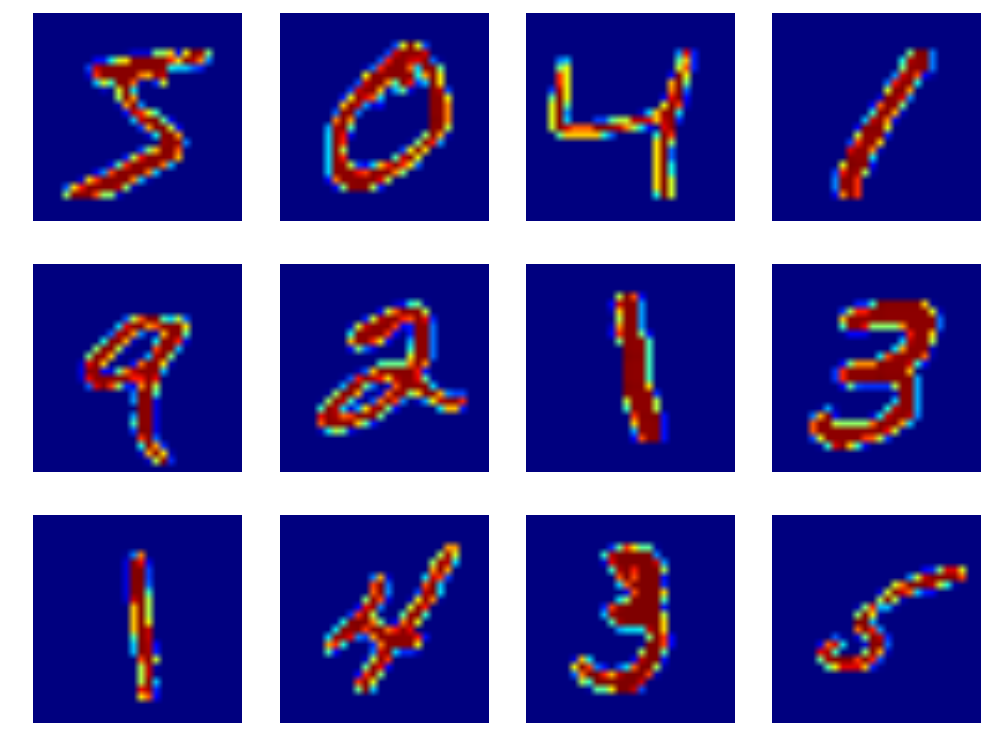

In [6]:
plt.figure(figsize=(10,10))
dim = (4,4)

for i in range(12):
    plt.subplot(dim[0], dim[1],i+1)
    img = X_train[i, 0, :, :]
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.iterable = val

In [7]:
shp = X_train.shape[1:]
dropout_rate = 0.25
opt = Adam(lr=1e-4)
dopt = Adam(lr=1e-3)
nch = 200

#Build generative model
g_input = Input(shape=[100])
H = Dense(nch*14*14, init='glorot_normal')(g_input)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Reshape( [nch, 14, 14] )(H)
H = UpSampling2D( size = (2,2))(H)
H = Convolution2D(nch/2, 3,3, border_mode='same', init='glorot_normal')(H)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Convolution2D(nch/4, 3,3, border_mode='same', init='glorot_normal')(H)
H = BatchNormalization(mode=2)(H)
H = Activation('relu')(H)
H = Convolution2D(1, 1, 1, border_mode='same', init='glorot_normal')(H)
g_v = Activation('sigmoid')(H)
generator = Model(g_input, g_v)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()

#Build discriminitive model

d_input = Input(shape=shp)
H = Convolution2D(256, 5, 5, subsample=(2,2), border_mode='same', activation='relu')(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(512, 5, 5, subsample=(2,2), border_mode='same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_v = Dense(2, activation='softmax')(H)
discriminator = Model(d_input, d_v)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()
make_trainable(discriminator, False) #Freeze weights for GAN stacked training

#Build stacked GAN model
gan_input = Input(shape=[100])
H = generator(gan_input)
gan_v = discriminator(H)
GAN = Model(gan_input, gan_v)
GAN.compile(loss='categorical_crossentropy', optimizer=opt)
GAN.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 39200)         3959200     input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 39200)         78400       dense_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 39200)         0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [8]:
def plot_loss(losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.figure(figsize=(10,8))
    plt.plot(losses["d"], label='discriminitive loss')
    plt.plot(losses['g'], label='generative loss')
    plt.legend()
    plt.show()

In [27]:
def plot_gen(n_ex=16, dim=(4,4), figsize=(10,10)):
    noise = np.random.uniform(0,1,size=[n_ex, 100])
    generated_images = generator.predict(noise)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1],i+1)
        img = generated_images[i, 0, :, :]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [10]:
ntrain = 10000

trainidx = random.sample(range(0, X_train.shape[0]), ntrain)
XT = X_train[trainidx,:,:,:]

#Pre train the discriminator network
noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
generated_images = generator.predict(noise_gen)
X = np.concatenate((XT, generated_images))
n = XT.shape[0]
y = np.zeros([2*n, 2])
y[:n,1] = 1
y[n:,0] = 1

make_trainable(discriminator, True)
discriminator.fit(X, y, nb_epoch=1, batch_size=128)
y_hat = discriminator.predict(X)

Epoch 1/1
20000/20000 [==============================] - 961s - loss: 0.0385      

In [11]:
y_hat_idx = np.argmax(y_hat, axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print("Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot))

accuracy: 100.00 pct (20000 of 20000) right


In [13]:
#set up Loss storage vector
losses = {"d":[], "g":[]}

In [25]:
def train_for_n(nb_epoch=1000, plt_frq=25, batch_size=32):
`    for e in tqdm(range(nb_epoch)):
        #Make generative images
        image_batches = X_train[np.random.randint(0, X_train.shape[0],size=batch_size), :,:,:]
        noise_gen = np.random.uniform(0,1,size=[batch_size,100])
        generated_images = generator.predict(noise_gen)
        
        #Train discriminator on generated images
        X = np.concatenate((image_batches, generated_images))
        y = np.zeros([2*batch_size,2])
        y[0:batch_size,1] = 1
        y[batch_size:,0] = 1
        
        #make trainable (discriminator, True)
        
        d_loss = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
        
        #Train generator discriminator stack on input noise to non generated output class
        
        noise_tr = np.random.uniform(0,1,size=[batch_size,100])
        y2 = np.zeros([batch_size,2])
        y2[:,1] = 1
        
        #make trainable (discriminator, False)
        
        g_loss = GAN.train_on_batch(noise_tr, y2)
        losses["g"].append(g_loss)
        
        #Update plots
        if e%plt_frq == plt_frq-1:
            plot_loss(losses)
            plot_gen()

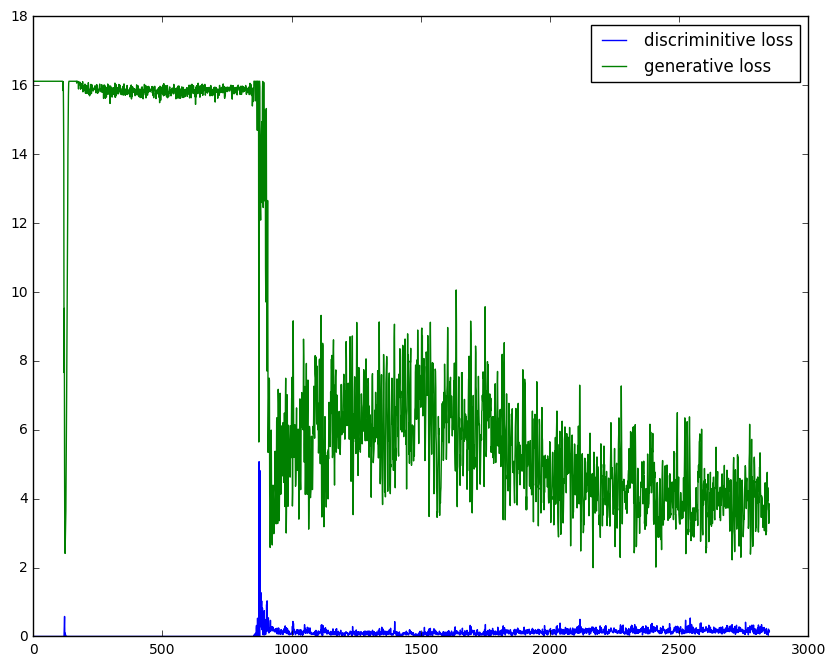

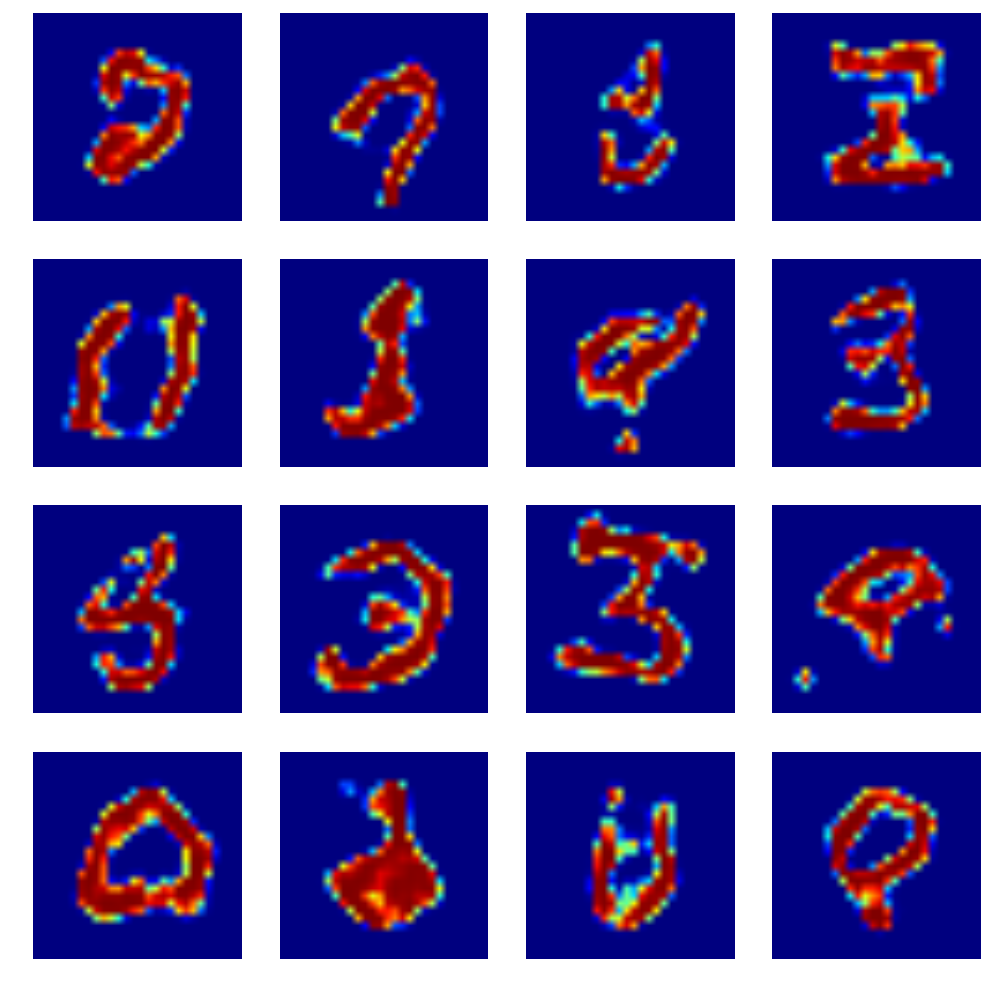





 46%|████▋     | 2775/6000 [24:57:03<8:13:41,  9.19s/it]



 46%|████▋     | 2776/6000 [24:57:12<8:00:02,  8.93s/it]



 46%|████▋     | 2777/6000 [24:57:22<8:25:28,  9.41s/it]



 46%|████▋     | 2778/6000 [24:57:31<8:12:11,  9.17s/it]



 46%|████▋     | 2779/6000 [24:57:39<7:52:31,  8.80s/it]



 46%|████▋     | 2780/6000 [24:57:47<7:38:24,  8.54s/it]



 46%|████▋     | 2781/6000 [24:57:55<7:27:50,  8.35s/it]



 46%|████▋     | 2782/6000 [24:58:06<8:14:45,  9.22s/it]



 46%|████▋     | 2783/6000 [24:58:15<8:03:51,  9.02s/it]



 46%|████▋     | 2784/6000 [24:58:23<7:49:52,  8.77s/it]



 46%|████▋     | 2785/6000 [24:58:31<7:41:14,  8.61s/it]



 46%|████▋     | 2786/6000 [24:58:39<7:34:39,  8.49s/it]



 46%|████▋     | 2787/6000 [24:58:49<7:58:23,  8.93s/it]



 46%|████▋     | 2788/6000 [24:58:58<7:50:54,  8.80s/it]

KeyboardInterrupt: 

In [28]:
train_for_n(nb_epoch=6000, plt_frq=25, batch_size=32)

In [29]:
opt.lr.set_value(1e-5)
dopt.lr.set_value(1e-4)
train_for_n(nb_epoch=2000, plt_frq=25, batch_size=32)

AttributeError: 'Variable' object has no attribute 'set_value'

In [ ]:
opt.lr.set_value(1e-6)
dopt.lr.set_value(1e-5)
train_for_n(nb_epoch=2000, plt_frq=25, batch_size=32)

In [ ]:
plot_loss(losses)

In [ ]:
plot_gen(25,(5,5),(12,12))

In [31]:
def plot_real(n_ex=16, dim=(4,4), figsize=(10,10) ):
    idx = np.random.randint(0,X_train.shape[0], n_ex)
    generated_images = X_train[idx,:,:,:]
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

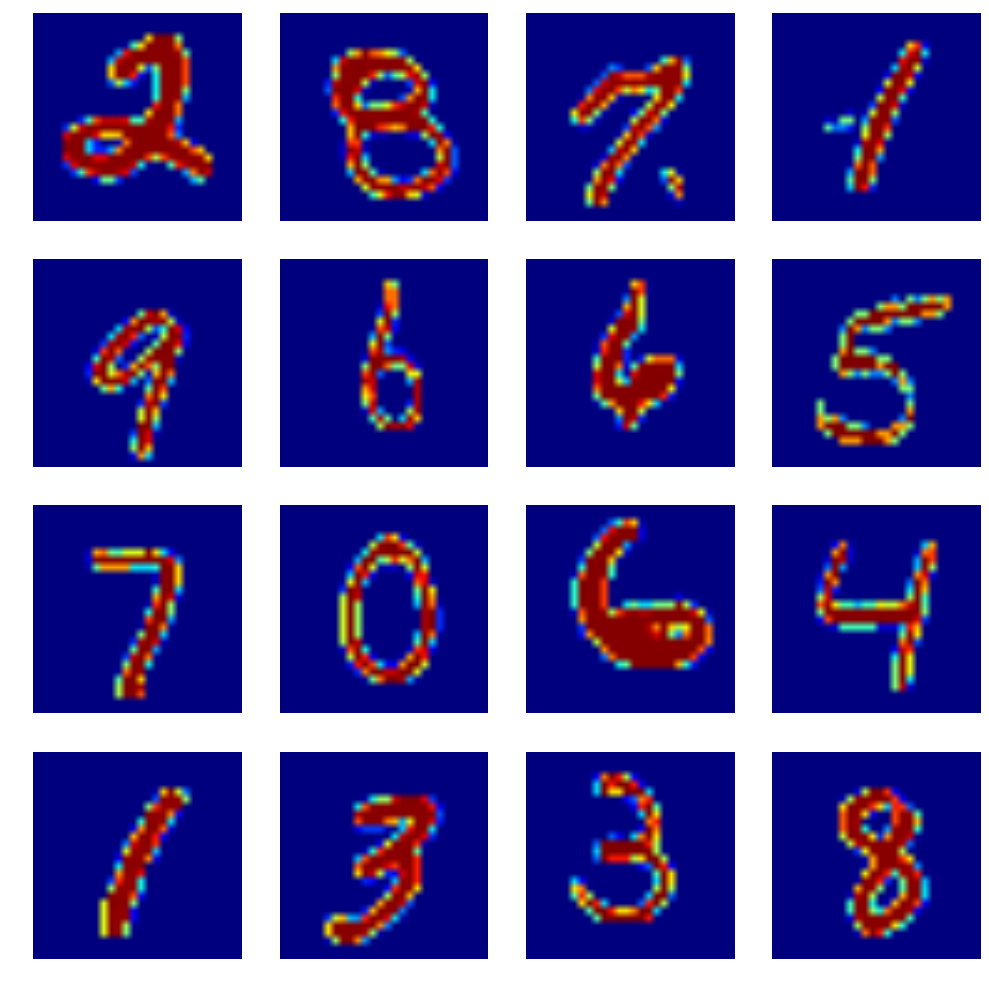

In [32]:
plot_real()